## Packed Padded Sequences, Masking, Inference and BLEU

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from torchtext.legacy.datasets import Multi30k
from torchtext.legacy.data import Field, BucketIterator

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

import spacy
import numpy as np

import random
import math
import time

import warnings
warnings.simplefilter('ignore')

In [2]:
SEED = 1234

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

In [3]:
import spacy.cli 
spacy.cli.download("en_core_web_sm")
spacy.cli.download("de_core_news_sm")

✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
✔ Download and installation successful
You can now load the package via spacy.load('de_core_news_sm')


In [4]:
# Creating tokenizers
spacy_de = spacy.load('de_core_news_sm')
spacy_en = spacy.load('en_core_web_sm')

In [5]:
def tokenize_de(text):
    """
    Tokenizes German text from a string into a list of strings (tokens)
    
    :param text: the german sentence
    """
    
    return [tok.text for tok in spacy_de.tokenizer(text)]

def tokenize_en(text):
    """
    Tokenizes English text from a string into a list of strings (tokens)
    
    :param text: the english sentence
    """
    
    return [tok.text for tok in spacy_en.tokenizer(text)]

In [6]:
# Source is in German and Target is in English

SRC = Field(tokenize = tokenize_de,
            init_token = '<sos>',
            eos_token = '<eos>',
            lower = True,
            include_lengths = True)

TRG = Field(tokenize = tokenize_en,
            init_token = '<sos>',
            eos_token = '<eos>',
            lower = True)

In [7]:
# Download and load the train, valid and test data

train_data, valid_data, test_data = Multi30k.splits(
    exts = ('.de', '.en'),
    fields = (SRC, TRG)
)

downloading training.tar.gz


training.tar.gz: 100%|██████████| 1.21M/1.21M [00:02<00:00, 567kB/s]


downloading validation.tar.gz


validation.tar.gz: 100%|██████████| 46.3k/46.3k [00:00<00:00, 174kB/s]


downloading mmt_task1_test2016.tar.gz


mmt_task1_test2016.tar.gz: 100%|██████████| 66.2k/66.2k [00:00<00:00, 166kB/s]


In [8]:
# Verifying

print(f"Number of training examples: {len(train_data.examples)}")
print(f"Number of validation examples: {len(valid_data.examples)}")
print(f"Number of testing examples: {len(test_data.examples)}")

print(vars(train_data.examples[0]))

Number of training examples: 29000
Number of validation examples: 1014
Number of testing examples: 1000
{'src': ['zwei', 'junge', 'weiße', 'männer', 'sind', 'im', 'freien', 'in', 'der', 'nähe', 'vieler', 'büsche', '.'], 'trg': ['two', 'young', ',', 'white', 'males', 'are', 'outside', 'near', 'many', 'bushes', '.']}


In [9]:
# building vocabulary
# min_freq => min threshold to include the word in the vocab

SRC.build_vocab(train_data, min_freq=2)
TRG.build_vocab(train_data, min_freq=2)

In [10]:
# Unique Tokens
print(f"Unique tokens in source (de) vocabulary: {len(SRC.vocab)}")
print(f"Unique tokens in target (en) vocabulary: {len(TRG.vocab)}")

Unique tokens in source (de) vocabulary: 7853
Unique tokens in target (en) vocabulary: 5893


## Creating Iterators

In [11]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [12]:
BATCH_SIZE = 128

train_iterator, valid_iterator, test_iterator = BucketIterator.splits(
    (train_data, valid_data, test_data),
    batch_size = BATCH_SIZE,
    sort_within_batch = True,
    sort_key = lambda x : len(x.src),
    device = device
)

## Building the Seq2Seq Model

### Encoder

In [13]:
class Encoder(nn.Module):
    
    def __init__(self, input_dim, emb_dim, enc_hid_dim, dec_hid_dim, dropout):
        """
        :param input_dim: It is the size/dimensionality of the one-hot vectors that will be input to the encoder. 
                        This is equal to the input (source) vocabulary size.
        :param emb_dim: It is the dimensionality of the embedding layer. 
                        This layer converts the one-hot vectors into dense vectors with emb_dim dimensions.
        :param enc_hid_dim: It is the dimensionality of the hidden state of the encoder
        :param dec_hid_dim: It is the dimensionality of the hidden state of the decoder
                        Actually, we will convert the output vectors from the GRU, to a 
                        Linear Layer, so that its dimension matches with that of the decoder
        :param dropout: It is the amount of dropout to use. 
                        This is a regularization parameter to prevent overfitting.
        """
        
        super().__init__()
        
        self.embedding = nn.Embedding(input_dim, emb_dim)
        
        self.rnn = nn.GRU(emb_dim, enc_hid_dim, bidirectional=True)
        
        self.fc = nn.Linear(enc_hid_dim * 2, dec_hid_dim)
        
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, src, src_len):
        
        # src.shape => (src_len, batch_size)
        # src_len => (batch_size)
        
        embedded = self.dropout(self.embedding(src))
        # embedded.shape => (src_len, batch_size, emb_dim)
        
        # need to explicitly put lengths on cpu
        packed_embedded = nn.utils.rnn.pack_padded_sequence(embedded, src_len.to('cpu'))
        
        packed_outputs, hidden = self.rnn(packed_embedded)
        # packed_outputs is a PACKED sequence containing all hidden state
        # hidden is now from the final non-padded element in the batch
        
        outputs, _ = nn.utils.rnn.pad_packed_sequence(packed_outputs)
        # outputs is now a NON-PACKED sequence, all hidden states obtained when the input
        # is a pad token are all zeros
        
        # outputs.shape => (src_len, batch_size, enc_hid_dim * n_directions)
        # hidden.shape => (n_layers * n_directions, batch_size, enc_hid_dim)
        
        # here, n_directions = 2
        # hidden is stacked as [forward1, backward1, forward2, backward2, ..., forward_batch_size, backward_batch_size]
        # outputs are always from the last layer
        
        # hidden[-2, :, :] --> last of the forwards RNN
        # hidden[-1, :, :] --> last of the backwards RNN
        
        # initial decoder hidden = final hidden state of the forwards and backwards FOR ALL BATCHES
        # encoder RNNs fed through a linear layer
        hidden = torch.tanh(
            self.fc(
                torch.cat((hidden[-2, :, :], hidden[-1, :, :]),
                dim = 1)
            )
        )
        
        # outputs.shape => (src_len, batch_size, enc_hid_dim * 2)
        # hidden.shape => (batch_size, dec_hid_dim)
        
        return outputs, hidden

### Attention
#### (with masking)

- The forward method now takes a mask input. This is a [batch size, source sentence length] tensor that is 1 when the source sentence token is not a padding token, and 0 when it is a padding token. For example, if the source sentence is: ["hello", "how", "are", "you", "?", <pad>, <pad>], then the mask would be [1, 1, 1, 1, 1, 0, 0].

In [14]:
class Attention(nn.Module):
    
    def __init__(self, enc_hid_dim, dec_hid_dim):
        """
        :param enc_hid_dim: It is the dimensionality of the hidden state of the encoder
        :param dec_hid_dim: It is the dimensionality of the hidden state of the decoder
        """
        
        super().__init__()
        
        self.attn = nn.Linear((enc_hid_dim * 2) + dec_hid_dim, dec_hid_dim)
        
        self.v = nn.Linear(dec_hid_dim, 1, bias = False)
        
    def forward(self, hidden, encoder_outputs, mask):
        
        # hidden.shape => (batch_size, dec_hid_dim)
        # encoder_outputs.shape => (src_len, batch_size, enc_hid_dim * 2)
        # 2 because n_directions = 2
        
        batch_size = encoder_outputs.shape[1]
        src_len = encoder_outputs.shape[0]
        
        # repeat decoder hidden state src_len times
        hidden = hidden.unsqueeze(1).repeat(1, src_len, 1)
        # hidden.shape => (batch_size, src_len, dec_hid_dim)
        
        encoder_outputs = encoder_outputs.permute(1, 0, 2)
        # encoder_outputs.shape => (batch_size, src_len, enc_hid_dim * 2)
        
        energy = torch.tanh(
            self.attn(
                torch.cat((hidden, encoder_outputs), dim = 2)
            )
        )
        # energy.shape => (batch_size, src_len, dec_hid_dim)
        
        attention = self.v(energy).squeeze(2)
        # attention.shape => (batch_size, src_len)
        
        # masking values that are 0 (pad) to -inf
        # meaning, they should be given least attention!!
        attention = attention.masked_fill(mask == 0, -1e10)
        
        return F.softmax(attention, dim = 1)

### Decoder

In [15]:
class Decoder(nn.Module):
    
    def __init__(self, output_dim, emb_dim, enc_hid_dim, dec_hid_dim, dropout, attention):
        """
        :param output_dim: It is the size/dimensionality of the one-hot vectors that will be the output of the decoder.
                        This is equal to the output (target) vocabulary size.
        :param emb_dim: It is the dimensionality of the embedding layer. 
                        This layer converts the one-hot vectors into dense vectors with emb_dim dimensions.
        :param enc_hid_dim: It is the dimensionality of the hidden state of the encoder
        :param dec_hid_dim: It is the dimensionality of the hidden state of the decoder (GRU)
        :param dropout: It is the amount of dropout to use. 
                        This is a regularization parameter to prevent overfitting.
        :param attention: the attention class object
        """
        
        super().__init__()
        
        self.output_dim = output_dim
        
        self.attention = attention
        
        self.embedding = nn.Embedding(output_dim, emb_dim)
        
        self.rnn = nn.GRU((enc_hid_dim * 2) + emb_dim, dec_hid_dim)
        
        self.fc_out = nn.Linear((enc_hid_dim * 2) + dec_hid_dim + emb_dim, output_dim)
        
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, input, hidden, encoder_outputs, mask):
        
        # input.shape => (batch_size,)
        # hidden.shape => (batch_size, dec_hid_dim)
        # encoder_outputs.shape => (src_len, batch_size, enc_hid_dim * 2)
        # mask => (batch_size, src_len)
        
        input = input.unsqueeze(0)
        # input.shape => (1, batch_size)
        
        embedded = self.dropout(self.embedding(input))
        # embedded.shape => (1, batch_size, emb_dim)
        
        a = self.attention(hidden, encoder_outputs, mask)
        # a.shape => (batch_size, src_len)
        
        a = a.unsqueeze(1)
        # a.shape => (batch_size, 1, src_len)
        
        encoder_outputs = encoder_outputs.permute(1, 0, 2)
        # encoder_outputs.shape => (batch_size, src_len, enc_hid_dim * 2)
        
        weighted = torch.bmm(a, encoder_outputs)
        # a1 : b X n X m
        # a2 : b X m X p
        # bmm(a1, a2) --> b X n X p
        
        # weighted.shape => (batch_size, 1, enc_hid_dim * 2)
        
        weighted = weighted.permute(1, 0, 2)
        # weighted.shape => (1, batch_size, enc_hid_dim * 2)
        
        rnn_input = torch.cat((embedded, weighted), dim = 2)
        # rnn.shape => (1, batch_size, (enc_hid_dim * 2) + emb_dim)
        
        output, hidden = self.rnn(rnn_input, hidden.unsqueeze(0))
        
        # output.shape => (seq_len, batch_size, dec_hid_dim * n_directions)
        # hidden.shape => (n_layers * n_directions, batch_size, dec_hid_dim)
        
        # as seq_len = 1
        # n_layers and n_directions = 1 in this decoder
        
        # output.shape => (1, batch_size, dec_hid_dim)
        # hidden.shape => (1, batch_size, dec_hid_dim)
        
        # implying that output == hidden
        
        assert (output == hidden).all()
        
        embedded = embedded.squeeze(0)
        # embedded.shape => (batch_size, emb_dim)
        
        output = output.squeeze(0)
        # output.shape => (batch_size, dec_hid_dim)
        
        weighted = weighted.squeeze(0)
        # weighted.shape => (batch_size, enc_hid_dim * 2)
        
        prediction = self.fc_out(
            torch.cat((output, weighted, embedded), dim = 1)
        )
        # prediction.shape => (batch_size, output_dim)
        
        return prediction, hidden.squeeze(0), a.squeeze(1)

### Seq2Seq Model

In [16]:
class Seq2Seq(nn.Module):
    
    def __init__(self, encoder, decoder, src_pad_idx, device):
        
        super().__init__()
        
        self.encoder = encoder
        self.decoder = decoder
        self.src_pad_idx = src_pad_idx # the index assigned to <pad> for src
        self.device = device
        
    def create_mask(self, src):
        """
            a method to create mask for the src sentence.
        :param src: the source sentence sequence
                    src.shape => (src_len, batch_size)
                    
        :return mask: the corresponding mask for the src sentence
                    mask.shape => (batch_size, src_len)
        """
        
        mask = (src != self.src_pad_idx).permute(1, 0)
        return mask
    
    def forward(self, src, src_len, trg, teacher_forcing_ratio = 0.5):
        """
        :param src: the source sentence sequence
                    src.shape => (src_len, batch_size)
        :param src_len: the src_len for each sentence in the batch
                    src_len.shape => (batch_size,)
        :param trg: the target sentence sequence
                    trg.shape => (trg_len, batch_size)
        :param teacher_forcing_ratio: the ratio, used for training. It tells 
                    by how much probability, we should use the decoded token or
                    the original token for training
                    e.g. if teacher_forcing_ratio is 0.75, 
                    we use ground-truth inputs 75% of the time.
        """
        
        batch_size = src.shape[1]
        trg_len = trg.shape[0]
        trg_vocab_size = self.decoder.output_dim
        
        # tensor to store decoder outputs
        outputs = torch.zeros(trg_len, batch_size, trg_vocab_size).to(self.device)
        
        # encoder_outputs is all hidden states of the input sequence, forwards and backwards
        # hidden is the final forward and backward hidden states, passed through a linear layer
        encoder_outputs, hidden = self.encoder(src, src_len)
        
        # first input to the decoder is the <sos> tokens
        input = trg[0, :]
        
        mask = self.create_mask(src)
        # mask.shape => (batch_size, src_len)
        
        for t in range(1, trg_len):
            
            # insert input token embedding, previous hidden state, all encoder hidden states and mask
            # receive output tensor (predictions) and new hidden state
            output, hidden, _ = self.decoder(input, hidden, encoder_outputs, mask)
            
            # place predictions in a tensor holding predictions for each token
            outputs[t] = output
            
            # decide if we are going to use teacher forcing or not
            teacher_force = random.random() < teacher_forcing_ratio
            
            # get the highest predicted token from our predictions
            top1 = output.argmax(1)
            
            # if teacher forcing, use actual next token as next input
            # if not, use predicted token
            input = trg[t] if teacher_force else top1
            
        return outputs

## Training the Seq2Seq Model

### Init the Model

In [17]:
INPUT_DIM = len(SRC.vocab)
OUTPUT_DIM = len(TRG.vocab)
ENC_EMB_DIM = 256
DEC_EMB_DIM = 256
ENC_HID_DIM = 512
DEC_HID_DIM = 512
ENC_DROPOUT = 0.5
DEC_DROPOUT = 0.5
SRC_PAD_IDX = SRC.vocab.stoi[SRC.pad_token]

attn = Attention(ENC_HID_DIM, DEC_HID_DIM)
enc = Encoder(INPUT_DIM, ENC_EMB_DIM, ENC_HID_DIM, DEC_HID_DIM, ENC_DROPOUT)
dec = Decoder(OUTPUT_DIM, DEC_EMB_DIM, ENC_HID_DIM, DEC_HID_DIM, DEC_DROPOUT, attn)

model = Seq2Seq(enc, dec, SRC_PAD_IDX, device).to(device)

We will initialize all biases to zero and all weights from $\mathcal{N}(0, 0.01)$.

In [18]:
def init_weights(m):
    """
        initializes the weights of the model.
    """
    
    for name, param in m.named_parameters():
        if 'weight' in name:
            nn.init.normal_(param.data, mean=0, std=0.01)
        else:
            nn.init.constant_(param.data, 0)


model.apply(init_weights)

Seq2Seq(
  (encoder): Encoder(
    (embedding): Embedding(7853, 256)
    (rnn): GRU(256, 512, bidirectional=True)
    (fc): Linear(in_features=1024, out_features=512, bias=True)
    (dropout): Dropout(p=0.5, inplace=False)
  )
  (decoder): Decoder(
    (attention): Attention(
      (attn): Linear(in_features=1536, out_features=512, bias=True)
      (v): Linear(in_features=512, out_features=1, bias=False)
    )
    (embedding): Embedding(5893, 256)
    (rnn): GRU(1280, 512)
    (fc_out): Linear(in_features=1792, out_features=5893, bias=True)
    (dropout): Dropout(p=0.5, inplace=False)
  )
)

In [19]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 20,518,405 trainable parameters


In [20]:
# define the optimizer
optimizer = optim.Adam(model.parameters())

In [21]:
# loss function
# NOTE: Our loss function calculates the average loss per token, 
# however by passing the index of the <pad> token as the ignore_index argument 
# we ignore the loss whenever the target token is a padding token.

TRG_PAD_IDX = TRG.vocab.stoi[TRG.pad_token]

criterion = nn.CrossEntropyLoss(ignore_index = TRG_PAD_IDX)

## Training Function

In [22]:
def train(model, iterator, optimizer, criterion, clip):
    
    model.train()
    
    epoch_loss = 0
    
    for i, batch in enumerate(iterator):
        
        src, src_len = batch.src
        trg = batch.trg
        
        optimizer.zero_grad()
        
        output = model(src, src_len, trg)
        
        # trg.shape => (trg_len, batch_size)
        # output.shape => (trg_len, batch_size, output_dim)
        
        output_dim = output.shape[-1]
        
        output = output[1:].view(-1, output_dim)
        trg = trg[1:].view(-1)
        
        # We have removed the <sos> token
        # trg.shape => ((trg_len - 1) * batch_size)
        # output.shape => ((trg_len - 1) * batch_size, output_dim)
        
        # NOTE:  the loss function only works on 2d inputs with 1d targets
        # we need to flatten each of them with .view
        
        loss = criterion(output, trg)
        
        loss.backward()
        
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        
        optimizer.step()
        
        epoch_loss += loss.item()
        
    return epoch_loss / len(iterator)

## Evaluate Function

In [23]:
def evaluate(model, iterator, criterion):
    
    model.eval()
    
    epoch_loss = 0
    
    with torch.no_grad():
    
        for i, batch in enumerate(iterator):

            src, src_len = batch.src
            trg = batch.trg

            output = model(src, src_len, trg, 0) #turn off teacher forcing

            # trg.shape => (trg_len, batch_size)
            # output.shape => (trg_len, batch_size, output_dim)

            output_dim = output.shape[-1]
            
            output = output[1:].view(-1, output_dim)
            trg = trg[1:].view(-1)

            # We have removed the <sos> token
            # trg.shape => ((trg_len - 1) * batch_size)
            # output.shape => ((trg_len - 1) * batch_size, output_dim)

            # NOTE:  the loss function only works on 2d inputs with 1d targets
            # we need to flatten each of them with .view

            loss = criterion(output, trg)

            epoch_loss += loss.item()
        
    return epoch_loss / len(iterator)

In [24]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [25]:
N_EPOCHS = 15
CLIP = 1

best_valid_loss = float('inf')

for epoch in range(N_EPOCHS):
    
    start_time = time.time()
    
    train_loss = train(model, train_iterator, optimizer, criterion, CLIP)
    valid_loss = evaluate(model, valid_iterator, criterion)
    
    end_time = time.time()
    
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'tut4-model.pt')
    
    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}')

Epoch: 01 | Time: 0m 40s
	Train Loss: 5.049 | Train PPL: 155.942
	 Val. Loss: 4.777 |  Val. PPL: 118.770
Epoch: 02 | Time: 0m 39s
	Train Loss: 4.092 | Train PPL:  59.880
	 Val. Loss: 4.128 |  Val. PPL:  62.080
Epoch: 03 | Time: 0m 39s
	Train Loss: 3.325 | Train PPL:  27.796
	 Val. Loss: 3.573 |  Val. PPL:  35.633
Epoch: 04 | Time: 0m 39s
	Train Loss: 2.847 | Train PPL:  17.229
	 Val. Loss: 3.341 |  Val. PPL:  28.240
Epoch: 05 | Time: 0m 39s
	Train Loss: 2.473 | Train PPL:  11.860
	 Val. Loss: 3.235 |  Val. PPL:  25.417
Epoch: 06 | Time: 0m 39s
	Train Loss: 2.170 | Train PPL:   8.761
	 Val. Loss: 3.242 |  Val. PPL:  25.586
Epoch: 07 | Time: 0m 39s
	Train Loss: 1.940 | Train PPL:   6.961
	 Val. Loss: 3.156 |  Val. PPL:  23.465
Epoch: 08 | Time: 0m 39s
	Train Loss: 1.737 | Train PPL:   5.683
	 Val. Loss: 3.262 |  Val. PPL:  26.101
Epoch: 09 | Time: 0m 39s
	Train Loss: 1.581 | Train PPL:   4.858
	 Val. Loss: 3.291 |  Val. PPL:  26.861
Epoch: 10 | Time: 0m 39s
	Train Loss: 1.476 | Train PPL

In [26]:
model.load_state_dict(torch.load('tut4-model.pt'))

test_loss = evaluate(model, test_iterator, criterion)

print(f'| Test Loss: {test_loss:.3f} | Test PPL: {math.exp(test_loss):7.3f} |')

| Test Loss: 3.179 | Test PPL:  24.030 |


## Inference

In [27]:
def translate_sentence(sentence, src_field, trg_field, model, device, max_len = 50):
    """
        translate the given `sentence` in src lang to the trg lang.
    
    :param sentence: the sentence string in src lang
    :param src_field: the SRC Field object
    :param trg_field: the TRG Field object
    :param model: the Seq2Seq model
    :param device: gpu or cpu
    :param max_len: the maximum length permitted for the trg sentence
    """
    
    model.eval()
    
    # Sentence --> tokens
    if isinstance(sentence, str):
        nlp = spacy.load('de')
        tokens = [token.text.lower() for token in nlp(sentence)]
        
    else:
        tokens = [token.lower() for token in sentence]
    
    # adding <sos> and <eos>
    tokens = [src_field.init_token] + tokens + [src_field.eos_token]
    
    # Tokens --> list of indices, acc. to SRC vocab
    src_indexes = [src_field.vocab.stoi[token] for token in tokens]
    
    src_tensor = torch.LongTensor(src_indexes).unsqueeze(1).to(device)
    # src_tensor.shape => (src_len, 1), where 1 = batch_size
    
    src_len = torch.LongTensor([len(src_indexes)])
    # src_len.shape => (batch_size,) = (1,)
    # it contains the length of the sentence
    
    with torch.no_grad():
        encoder_outputs, hidden = model.encoder(src_tensor, src_len)
        
    mask = model.create_mask(src_tensor)
    
    # start with the <sos> token
    trg_indexes = [trg_field.vocab.stoi[trg_field.init_token]]
    
    attentions = torch.zeros(max_len, 1, len(src_indexes)).to(device)
    
    for i in range(max_len):
        
        # take the last trg token produced
        trg_tensor = torch.LongTensor([trg_indexes[-1]]).to(device)
        
        with torch.no_grad():
            output, hidden, attention = model.decoder(trg_tensor, hidden, encoder_outputs, mask)
            
            attentions[i] = attention
            
            pred_token = output.argmax(1).item()
            
            trg_indexes.append(pred_token)
            
            if pred_token == trg_field.vocab.stoi[trg_field.eos_token]:
                break
                
    trg_tokens = [trg_field.vocab.itos[i] for i in trg_indexes]
        
    return trg_tokens[1:], attentions[:len(trg_tokens)-1]

In [28]:
def display_attention(sentence, translation, attention):
    
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(111)
    
    attention = attention.squeeze(1).cpu().detach().numpy()
    
    cax = ax.matshow(attention, cmap='bone')
   
    ax.tick_params(labelsize=15)
    
    x_ticks = [''] + ['<sos>'] + [t.lower() for t in sentence] + ['<eos>']
    y_ticks = [''] + translation
     
    ax.set_xticklabels(x_ticks, rotation=45)
    ax.set_yticklabels(y_ticks)

    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()
    plt.close()

In [29]:
example_idx = 12

src = vars(train_data.examples[example_idx])['src']
trg = vars(train_data.examples[example_idx])['trg']

print(f'src = {src}')
print(f'trg = {trg}')

src = ['ein', 'schwarzer', 'hund', 'und', 'ein', 'gefleckter', 'hund', 'kämpfen', '.']
trg = ['a', 'black', 'dog', 'and', 'a', 'spotted', 'dog', 'are', 'fighting']


In [30]:
translation, attention = translate_sentence(src, SRC, TRG, model, device)

print(f'predicted trg = {translation}')

predicted trg = ['a', 'black', 'dog', 'and', 'a', 'spotted', 'dog', 'fighting', '.', '<eos>']


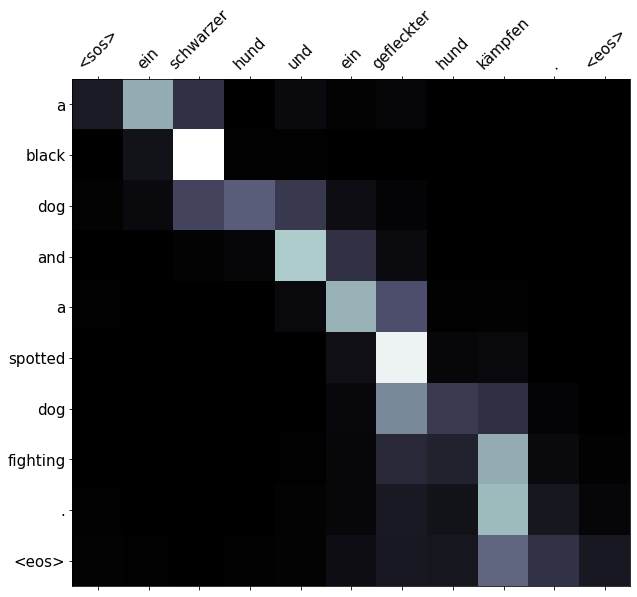

In [31]:
display_attention(src, translation, attention)

In [32]:
example_idx = 18

src = vars(test_data.examples[example_idx])['src']
trg = vars(test_data.examples[example_idx])['trg']

print(f'src = {src}')
print(f'trg = {trg}')

src = ['die', 'person', 'im', 'gestreiften', 'shirt', 'klettert', 'auf', 'einen', 'berg', '.']
trg = ['the', 'person', 'in', 'the', 'striped', 'shirt', 'is', 'mountain', 'climbing', '.']


predicted trg = ['the', 'person', 'in', 'the', 'striped', 'shirt', 'is', 'climbing', 'a', 'mountain', '.', '<eos>']


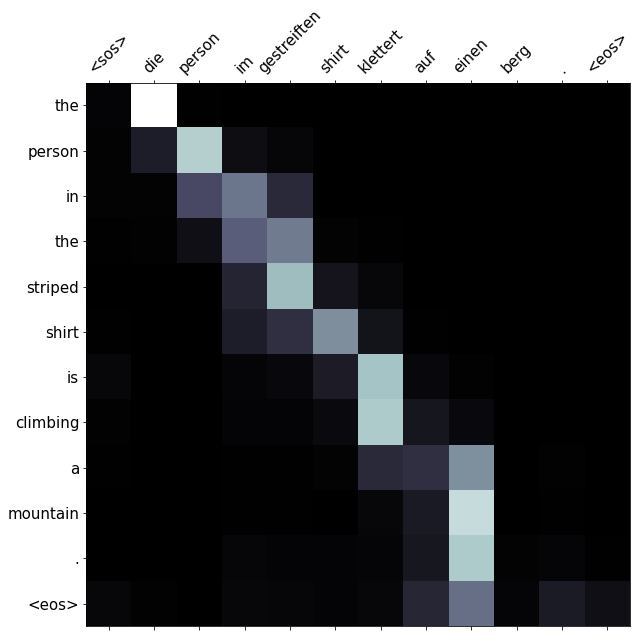

In [33]:
translation, attention = translate_sentence(src, SRC, TRG, model, device)

print(f'predicted trg = {translation}')

display_attention(src, translation, attention)

## BLEU Score

In [34]:
from torchtext.data.metrics import bleu_score

def calculate_bleu(data, src_field, trg_field, model, device, max_len = 50):
    
    trgs = []
    pred_trgs = []
    
    for datum in data:
        
        src = vars(datum)['src']
        trg = vars(datum)['trg']
        
        pred_trg, _ = translate_sentence(src, src_field, trg_field, model, device, max_len)
        
        #cut off <eos> token
        pred_trg = pred_trg[:-1]
        
        pred_trgs.append(pred_trg)
        trgs.append([trg])
        
    return bleu_score(pred_trgs, trgs)

In [35]:
bleu_score = calculate_bleu(test_data, SRC, TRG, model, device)

print(f'BLEU score = {bleu_score*100:.2f}')

BLEU score = 29.00
